In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import requests
from bs4 import BeautifulSoup
import time
import seaborn as sns
# import folium


In [71]:
data = pd.read_csv('houses_current.csv')
data.head()
len(data)

9674

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9674 entries, 0 to 9673
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   houseTypes  9674 non-null   object 
 1   area        9497 non-null   float64
 2   num_floors  7706 non-null   float64
 3   bedrooms    7577 non-null   float64
 4   address     9674 non-null   object 
 5   price       9548 non-null   float64
 6   url         9674 non-null   object 
dtypes: float64(4), object(3)
memory usage: 529.2+ KB


REMOVE DUPLICATES

In [73]:
print('Sum of duplicates: ', data.duplicated(subset=['houseTypes', 'area', 'num_floors', 'bedrooms','address','price']).sum())
data = data.drop_duplicates(subset=['houseTypes', 'area', 'num_floors', 'bedrooms','address','price']).copy()
print('After removing duplicates: ', data.duplicated().sum())
print('Length of data then: ', len(data))

Sum of duplicates:  1066
After removing duplicates:  0
Length of data then:  8608


CONVERT OBJECT TO FLOAT64 AND STRING

In [74]:
data = data.astype({'houseTypes':'string','address':'string','url':'string'})

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8608 entries, 0 to 9673
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   houseTypes  8608 non-null   string 
 1   area        8447 non-null   float64
 2   num_floors  6798 non-null   float64
 3   bedrooms    6698 non-null   float64
 4   address     8608 non-null   string 
 5   price       8492 non-null   float64
 6   url         8608 non-null   string 
dtypes: float64(4), string(3)
memory usage: 538.0 KB


In [76]:
for col in data.columns:
    print('Ratio of missing data of ' + str(col) +': ' + str(round(data[col].isna().sum()*100/len(data[col]),3)) + '%')

Ratio of missing data of houseTypes: 0.0%
Ratio of missing data of area: 1.87%
Ratio of missing data of num_floors: 21.027%
Ratio of missing data of bedrooms: 22.189%
Ratio of missing data of address: 0.0%
Ratio of missing data of price: 1.348%
Ratio of missing data of url: 0.0%


In [77]:
data[['district','city']] = data['address'].apply(lambda x: pd.Series(str(x).split(', ')))

In [78]:
data = data.drop(['address'], axis=True)

In [79]:
data.reset_index(inplace=True, drop=True)

In [80]:
data = data[['houseTypes','area','num_floors','bedrooms','district','city','price','url']]

In [81]:
data.head()

,houseTypes,area,num_floors,bedrooms,district,city,price,url
0,Bán Nhà riêng,130.0,3.0,7.0,Quận 12,TP Hồ Chí Minh,9.200,https://batdongsan.vn/ban-biet-thu-san-vuon-qu...
1,Bán Nhà riêng,65.0,NaN,2.0,Ngũ Hành Sơn,Đà Nẵng,2.900,https://batdongsan.vn/29-ty-dien-tich-6580m2-n...
2,Bán Nhà riêng,90.0,5.0,5.0,Hai Bà Trưng,Hà Nội,14.000,https://batdongsan.vn/ban-nha-kim-nguu-phan-lo...
3,Bán Nhà riêng,50.0,5.0,5.0,Quận 3,TP Hồ Chí Minh,0.001,https://batdongsan.vn/quan-3-le-van-sy-5-tang-...
4,Bán Nhà riêng,30.0,1.0,2.0,Gò Vấp,TP Hồ Chí Minh,3.700,https://batdongsan.vn/nha-moi-full-noi-that-hx...


In [13]:
data.to_csv('houses.csv',index=False)
data.to_excel('houses.xlsx',index=False)

## Xử lí giá

In [82]:
low_noise_data = data.loc[(data['price'] < 0.1)]
hign_noise_data = data.loc[(data['price'] >= 500)]
null_price_data = data[data['price'].isna()]

In [19]:
low_noise_data = low_noise_data.copy()
low_noise_data.to_excel('error_price_low.xlsx', index=False)  

In [20]:
hign_noise_data = hign_noise_data.copy()
hign_noise_data.to_excel('error_price_hign.xlsx', index=False)  

c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

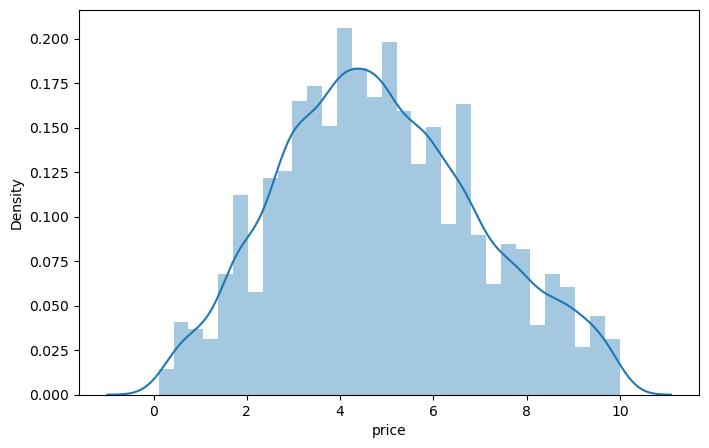

In [83]:
house_data_1 = data.loc[(data['price'] >= 0.1) & (data['price'] < 10)]
fig,ax = plt.subplots(figsize = (8,5))
sns.distplot(house_data_1['price'])

c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

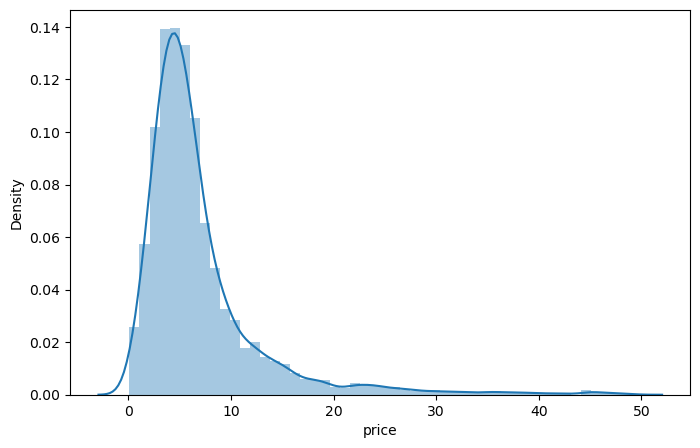

In [84]:
house_data_2 = data.loc[(data['price'] >= 0.1) & (data['price'] < 50)]
fig,ax = plt.subplots(figsize = (8,5))
sns.distplot(house_data_2['price'])

In [101]:
house_data = data.loc[(data['price'] >= 0.1) & (data['price'] < 500)]

In [54]:
house_data = data.loc[(data['price'] >= 0.1) & (data['price'] < 500)]
house_data.to_excel('house_data.xlsx', index=False)

C:\Users\84947\AppData\Local\Temp\ipykernel_18248\3740483212.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(house_data['price'])


<AxesSubplot: xlabel='price', ylabel='Density'>

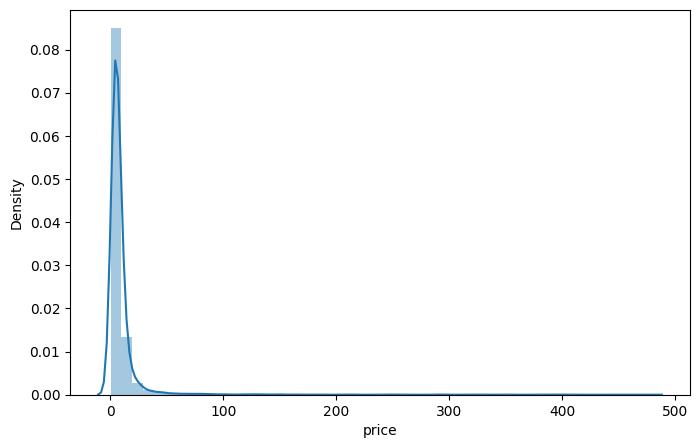

In [55]:
fig,ax = plt.subplots(figsize = (8,5))
sns.distplot(house_data['price'])

## Xử lí diện tích

In [102]:
house_data['area'].isna().sum()

124

In [103]:
house_data['area'].describe()

count      8142.000000
mean         97.477207
std        1148.948237
min           3.000000
25%          43.000000
50%          58.000000
75%          84.000000
max      100103.000000
Name: area, dtype: float64

In [104]:
house_data=house_data.loc[(house_data['area'] >=10) & (house_data['area'] <=20000)]

In [105]:
house_data['area'].describe()

count     8096.000000
mean        85.640689
std        303.197151
min         10.000000
25%         44.000000
50%         59.000000
75%         85.000000
max      18264.000000
Name: area, dtype: float64

C:\Users\84947\AppData\Local\Temp\ipykernel_18248\255560388.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(house_data_3['area'])


<AxesSubplot: xlabel='area', ylabel='Density'>

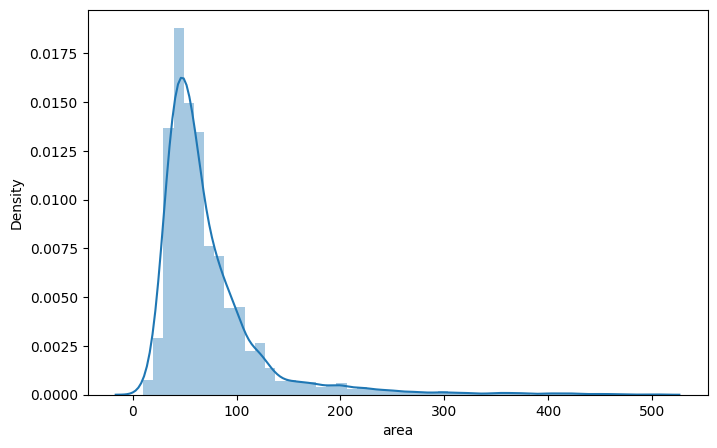

In [271]:
house_data_3 = house_data.loc[(house_data['area'] >=10) & (house_data['area'] <=500)]
fig,ax = plt.subplots(figsize = (8,5))
sns.distplot(house_data_3['area'])

# Xử lý num_floors



In [124]:
house_data['num_floors'].describe()

count    6416.000000
mean        3.223192
std         1.609810
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        11.000000
Name: num_floors, dtype: float64

In [125]:
filtered_data = house_data[house_data['num_floors'] > 11]
print(filtered_data[['num_floors', 'price']])


Empty DataFrame
Columns: [num_floors, price]
Index: []


In [126]:
house_data = house_data.drop(house_data[house_data['num_floors'] == 27].index).reset_index(drop=True)


In [127]:
house_data.loc[house_data['num_floors'] > 11, 'num_floors'] = 1
house_data.loc[house_data['num_floors'].isna(), 'num_floors'] = 1

In [128]:
house_data['num_floors'].describe()

count    8096.000000
mean        2.761858
std         1.693094
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        11.000000
Name: num_floors, dtype: float64

c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='num_floors', ylabel='Density'>

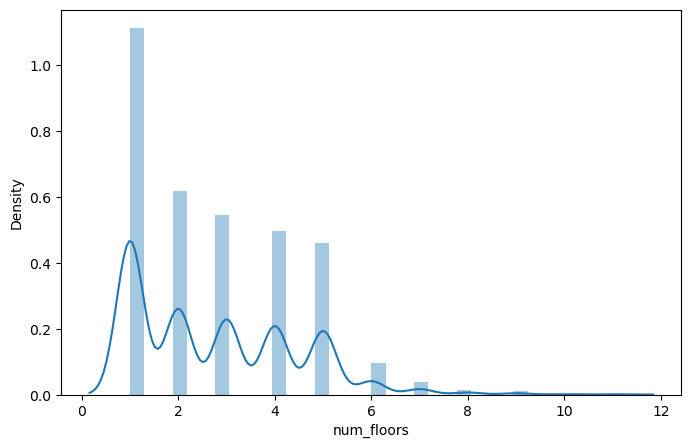

In [129]:
fig,ax = plt.subplots(figsize = (8,5))
sns.distplot(house_data['num_floors'])

In [130]:
house_data.isna().sum()

houseTypes       0
area             0
num_floors       0
bedrooms      1709
district         0
city             0
price            0
url              0
dtype: int64

# Xử lý bedrooms

In [131]:
house_data['bedrooms'].describe()

count    6387.000000
mean        3.703304
std         3.465249
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max       111.000000
Name: bedrooms, dtype: float64

c:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bedrooms', ylabel='Density'>

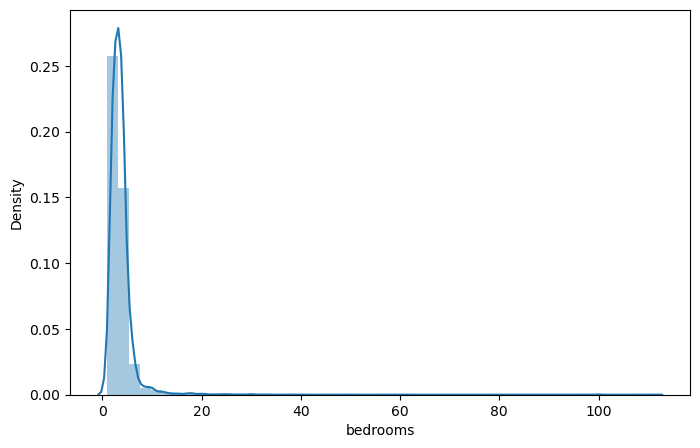

In [121]:
fig,ax = plt.subplots(figsize = (8,5))
sns.distplot(house_data['bedrooms'])

In [132]:
many_bedrooms = house_data[house_data['bedrooms']>20]
print(len(many_bedrooms))
print(many_bedrooms.head(30))
many_bedrooms.to_excel('many_bedrooms.xlsx', index=False)

30
           houseTypes    area  num_floors  bedrooms    district  \
610   Bán Nhà mặt phố  1518.0         1.0      30.0     Thủ Đức   
760   Bán Nhà mặt phố  1518.0         1.0      30.0     Thủ Đức   
814     Bán Nhà riêng   270.0         5.0      50.0    Tân Bình   
1175    Bán Nhà riêng   350.0         8.0     111.0    Tân Bình   
1295  Bán Nhà mặt phố   100.0         9.0      24.0     Sơn Trà   
1373    Bán Nhà riêng    77.0         2.0      33.0         Huế   
1645    Bán Nhà riêng    75.0         7.0      24.0  Thanh Xuân   
2318    Bán Nhà riêng   165.0         9.0      61.0    Cầu Giấy   
2385    Bán Nhà riêng   558.0         5.0      65.0      Quận 7   
2490  Bán Nhà mặt phố   435.0         9.0     100.0      Quận 7   
2790  Bán Nhà mặt phố   137.0         7.0      25.0      Quận 3   
3551  Bán Nhà mặt phố   800.0         5.0     100.0      Quận 7   
4143    Bán Nhà riêng    65.0         9.0      21.0   Thanh Trì   
4307  Bán Nhà mặt phố   170.0         6.0      28.0     Quậ

In [133]:
filtered_data2 = house_data[house_data['bedrooms'] > 20]
print(filtered_data2[['bedrooms', 'num_floors']])

      bedrooms  num_floors
610       30.0         1.0
760       30.0         1.0
814       50.0         5.0
1175     111.0         8.0
1295      24.0         9.0
1373      33.0         2.0
1645      24.0         7.0
2318      61.0         9.0
2385      65.0         5.0
2490     100.0         9.0
2790      25.0         7.0
3551     100.0         5.0
4143      21.0         9.0
4307      28.0         6.0
4361      36.0         3.0
4554      22.0         2.0
4743      27.0         6.0
4839      30.0         8.0
4875      30.0         8.0
5078      32.0         6.0
5081      40.0         9.0
5132      23.0         4.0
5134      25.0         3.0
5667      26.0         6.0
6299      28.0         4.0
7006      23.0         6.0
7352      33.0         6.0
7565      38.0         2.0
7685      21.0         6.0
7749      25.0         8.0


In [25]:
# new_low_price = []
# for url in low_noise_data['url']:
#     match = re.search(r'(\d+)-ty', url) or re.search(r'(\d+)ty-', url) or re.search(r'(\d+)-ti', url)
#     if match:
#         number = match.group(1)
#         if int(number) <= 10:
#             new_low_price.append(float(number))
#         elif int(number) <= 100:
#             new_low_price.append(float(number)/10)
#         else:
#             new_low_price.append(float(number)/100)
#     else:
#         match = re.search(r'(\d+)-trieu-', url) or re.search(r'(\d+)tr-', url) or re.search(r'(\d+)trieu-', url)
#         if match:
#             number = match.group(1)
#             new_low_price.append(float(number)/1000)
#         else:
#             new_low_price.append(0)
  
# -2ty5-    -70trm2-    -2x-ty-  -4ty95-    -2ty2x-     -shr6ty120-  -360trphan             

In [26]:
# new_price =[]
# count_error = 0
# for url in low_noise_data['url']:
#     match = re.search(r'(\d+)-ty', url) 
#     if match:
#         number = match.group(1)
#         if int(number) > 10 & int(number) < 100:
#             new_price.append(float(number)/10)
#         elif int(number) >= 100:
#             new_price.append(float(number)/100)
#         else:
#             new_price.append(float(number))
#     else:
#         match =  re.search(r'(\d+)tr', url)
#         if match:
#             new_price.append(float(match.group(1))/1000)
#         elif match == None:
#             try:
#                 data = requests.get(url)
#                 soup = BeautifulSoup(data.text, 'lxml')
#                 if data:
#                     if(soup.find('div',{'class':'project-global-object-block-003 information-custom'}) and soup.find('div',{'class':'content'})):
#                         text_info=""
#                         text_info = soup.find('div',{'class':'project-global-object-block-003 information-custom'}).text.strip() + soup.find('div',{'class':'content'}).text.strip().replace('\n','')
#                         text_info = text_info.replace("\r"," ")
#                         text_info = text_info.replace("\n"," ")
#                         text_info = text_info.replace("\t"," ")
#                         z = re.search(r"(\d+(?:\.\d+)?(?:,\d+)?) Tỷ", text_info, re.IGNORECASE)
#                         if z:
#                             new_price.append(float(z.group(1)))
#             except:
#                 print("error")
#                 new_price.append(0.00001)
#         else:
#             new_price.append(0.00001)

# len(low_noise_data)
# #low_noise_data['new_price'] = new_price
# new_price

In [135]:
len(house_data)

8096

In [134]:
print("Missing Values by Column")
print("-"*30)
print(house_data.isna().sum())
print("-"*30)
print("TOTAL MISSING VALUES:",data.isna().sum().sum())

Missing Values by Column
------------------------------
houseTypes       0
area             0
num_floors       0
bedrooms      1709
district         0
city             0
price            0
url              0
dtype: int64
------------------------------
TOTAL MISSING VALUES: 3997


<AxesSubplot:>

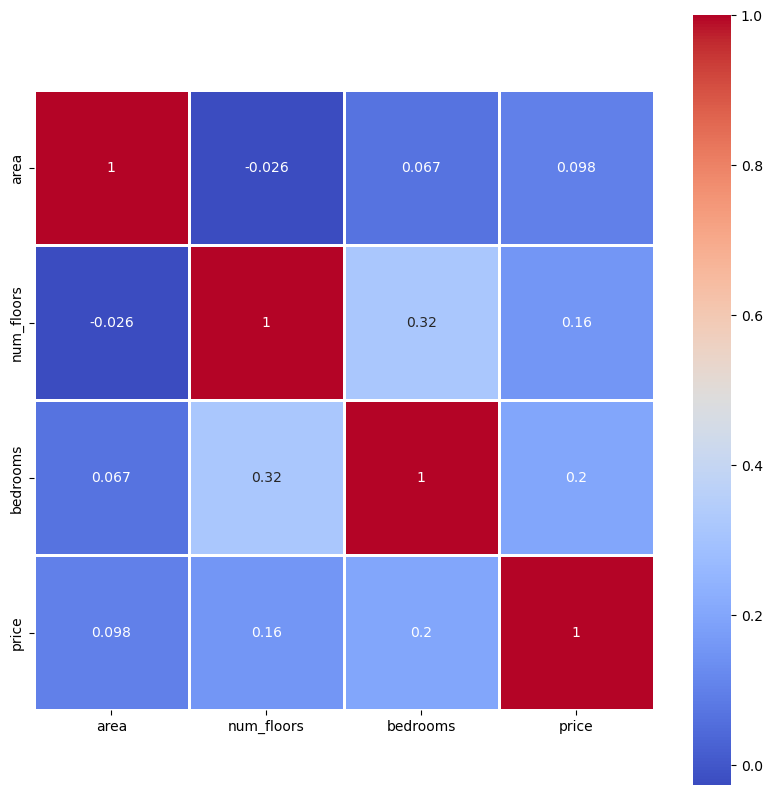

In [136]:
plt.figure(figsize=(10,10))
sns.heatmap(house_data.corr(), square=True ,annot=True, linewidths=1,cmap="coolwarm")

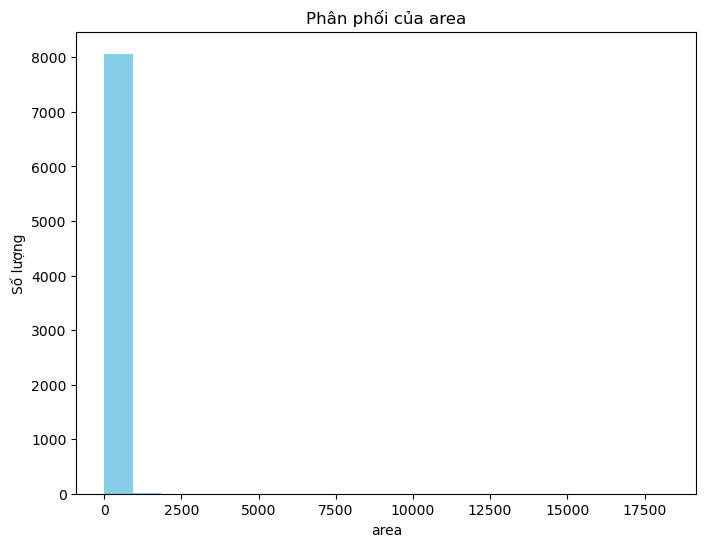

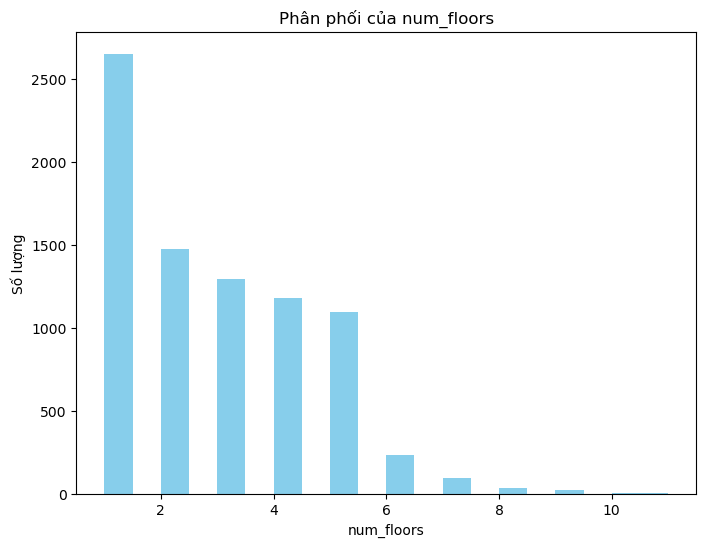

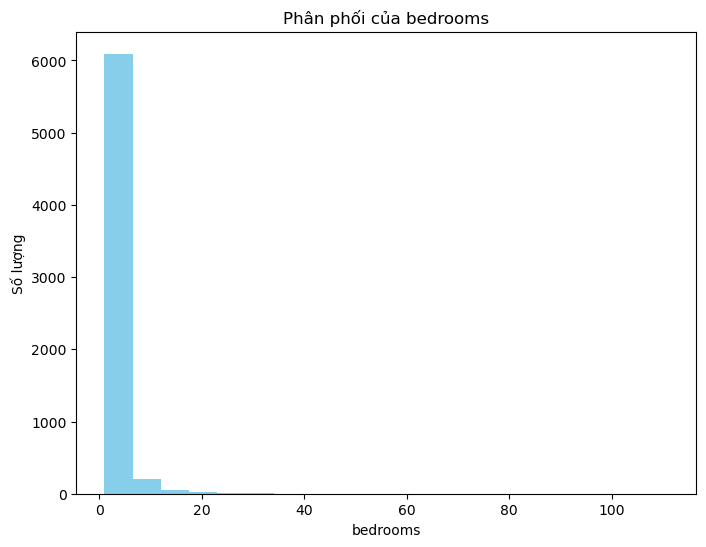

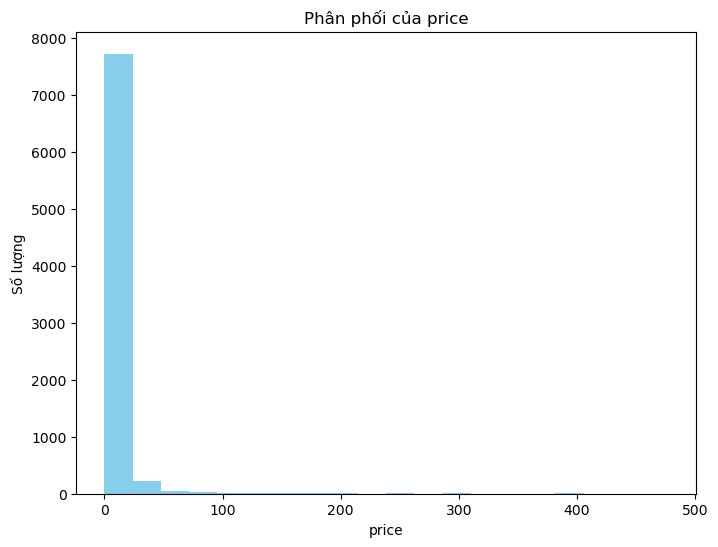

In [137]:

# Danh sách các feature cần xem phân phối
features = ['area','num_floors','bedrooms','price']

# Vẽ biểu đồ phân phối của các feature
for feature in features:
    plt.figure(figsize=(8, 6))
    plt.hist(house_data[feature], bins=20, color='skyblue')
    plt.xlabel(feature)
    plt.ylabel('Số lượng')
    plt.title('Phân phối của ' + feature)
    plt.show()

In [41]:
house_data['price'].fillna(0, inplace=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18968\17628545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_data['price'].fillna(0, inplace=True)


 # Initialize google map


In [45]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent='my_app')

# Tạo đối tượng geocoder
geocoder = geolocator.geocode

# Geocode the addresses to obtain latitude and longitude coordinates
locations = [geocoder(f"{district}, {city}") for district, city in zip(house_data['district'][0:100], house_data['city'][0:100])]

# Extract latitude and longitude coordinates from the locations
latitude = [location.latitude for location in locations]
longitude = [location.longitude for location in locations]

# Mark points on google map

In [46]:
lat = 10.861410750000001
long = 106.66420925636413
zoom = 6
gmap2 = folium.Map(location=(lat, long), zoom_start=zoom)
def _addMarker(latitudes, longitudes,gmap):
    # Kiểm tra độ dài của danh sách latitude và longitude
    if len(latitudes) != len(longitudes):
        print("Danh sách latitude và longitude không cùng độ dài.")
        return
    # Thêm Marker vào map_obj
    for lat, lng in zip(latitudes, longitudes):
        marker = folium.Marker(location=(lat, lng))
        marker.add_to(gmap)
_addMarker(latitude,longitude,gmap2)
gmap2.save("foliumMarkerMultiple.html")

# Heatmap

In [47]:
from folium.plugins import HeatMap

lat = 10.861410750000001
long = 106.66420925636413
zoom = 6
gmap2 = folium.Map(location=(lat, long), zoom_start=zoom)
maximum = max(house_data['price'])

def _addHeatMap(map_obj, latitudes, longitudes, values):
    # Tạo danh sách các tọa độ (latitude, longitude, value)
    data = list(zip(latitudes, longitudes, values))
    # Tạo HeatMap từ danh sách tọa độ và values
    heat_map = HeatMap(data)
    # Thêm HeatMap vào bản đồ
    map_obj.add_child(heat_map)
_addHeatMap(gmap2,latitude,longitude,house_data['price'][0:100])
gmap2.save("foliumHeatMap.html")